In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import fu, nu
from pandas import DataFrame
import os
import re

In [3]:

# Test all the methods used in this notebook in one test suite
import unittest
if ('../tests' not in sys.path): sys.path.insert(1, '../tests')
suite = unittest.TestSuite()

# Add all test cases from each class to the suite
from test_frvrs_utils_injury_functions import TestGetIsHemorrhageToolApplied, TestHemorrhageControlled
suite.addTest(unittest.makeSuite(TestGetIsHemorrhageToolApplied))
suite.addTest(unittest.makeSuite(TestHemorrhageControlled))

# Run the test suite
runner = unittest.TextTestRunner()
runner.run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.008s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>


# Analyze Issue with Logging Multiple TOOL_APPLIEDs
Normally, we check if a hemorrhage is controlled by identifying whether both an injury record and an injury treatment exist for a hemorrhage-related procedure. Unfortunately, the logs have intermittent instances of a _TOOL_APPLIED_ but no _INJURY_TREATED_ preceding it.

In [4]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='', first_responder_master_registry_scene_stats_df=''
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_file_stats_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_scene_stats_df.pkl.


In [5]:

elevens_df = fu.get_elevens_data_frame(
    triage_paper_df, file_stats_df, scene_stats_df,
    needed_columns=['scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'session_file_date']
)

In [6]:

from random import choices

# mask_series = elevens_df.session_file_date.map(lambda x: x.year > 2022)
mask_series = (elevens_df.session_uuid == 'b26d61b8-9027-4b16-ba3b-bc337bc6e681') & (elevens_df.scene_id == 0)
logs_df = elevens_df[mask_series]
mask_series = (logs_df.patient_id == 'Gloria_8 Root')
injury_df = choices([injury_df for _, injury_df in logs_df[mask_series].groupby(fu.injury_groupby_columns)], k=1)[0]

In [7]:

# Find patients with a tool applied not paired with an injury treated
non_paired_idx_list = []
for (session_uuid, scene_id, patient_id), patient_df in elevens_df.groupby(fu.patient_groupby_columns):
    action_mask_series = patient_df.action_type.isin(['TOOL_APPLIED'])
    for event_time, idx_df in patient_df[action_mask_series].groupby('event_time'):
        mask_series = patient_df.action_type.isin(['INJURY_TREATED']) & (patient_df.event_time == event_time)
        if not mask_series.any(): non_paired_idx_list.append(idx_df.sort_values('action_tick').index.tolist()[0])
mask_series = elevens_df.index.isin(non_paired_idx_list)
non_paired_df = elevens_df[mask_series]
mask_series = ~non_paired_df.tool_type.isnull()
non_paired_df = non_paired_df[mask_series]
mask_series = non_paired_df.tool_type.map(lambda x: fu.tool_type_to_required_procedure_dict.get(str(x), '') in fu.hemorrhage_control_procedures_list)
non_paired_df = non_paired_df[mask_series]

In [11]:

# Grab a random patient from the non-paired applications
patient_df = choices([patient_df for _, patient_df in non_paired_df.groupby(fu.patient_groupby_columns)], k=1)[0]
print(patient_df.shape)

# Get the whole patient history from the logs
mask_series = True
for (session_uuid, scene_id, patient_id), patient_df in patient_df.groupby(fu.patient_groupby_columns):
    for cn in fu.patient_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
    break
patient_df = elevens_df[mask_series]
print(patient_df.shape)

# Check if a hemorrhage control tool was applied for each injury of the patient
for injury_id, injury_df in patient_df.groupby('injury_id'):
    print(injury_id, fu.get_is_hemorrhage_tool_applied(injury_df, patient_df, verbose=False))

(1, 117)
(13, 117)
R Calf Shrapnel True


In [12]:

# Check if a hemorrhage control tool was applied for each injury of the patient
for injury_id, injury_df in patient_df.groupby('injury_id'):
    print(injury_id, fu.get_is_hemorrhage_tool_applied(injury_df, patient_df, verbose=True))

A hemorrhage-related TOOL_APPLIED event can be associated with the injury (R Calf Shrapnel): True
R Calf Shrapnel True


In [13]:

import pyperclip

setup_str = f"""
    def setUp(self):
        
        # Create mock dataframes for testing
        self.injury_df = DataFrame({{"""
for cn in ['patient_id', 'injury_record_required_procedure']: setup_str += f"""\n            '{cn}': {injury_df[cn].tolist()},"""
setup_str += f"""\n        }})
        self.logs_df = DataFrame({{"""
for cn in ['patient_id', 'tool_applied_type']: setup_str += f"""\n            '{cn}': {patient_df[cn].tolist()},"""
setup_str += f"""\n        }})"""
pyperclip.copy(setup_str)

In [ ]:

# Get the whole scene history from the random patient
mask_series = True
for (session_uuid, scene_id), scene_df in patient_df.groupby(fu.scene_groupby_columns):
    for cn in fu.scene_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
    break
logs_df = elevens_df[mask_series]
print(logs_df.shape)

In [6]:

# There is also a line (624) that has a Tool_Applied but no INJURY_TREATD preceding it. That seems odd to OSU.
mask_series = (elevens_df.action_type == 'TOOL_APPLIED') & (elevens_df.action_tick == 332915)
df = elevens_df[mask_series]
session_uuid = df.session_uuid.squeeze()
scene_id = df.scene_id.squeeze()
mask_series = (elevens_df.session_uuid == session_uuid) & (elevens_df.scene_id == scene_id)
scene624_df = elevens_df[mask_series]
patient_id = df.patient_id.squeeze()
mask_series &= (elevens_df.patient_id == patient_id)
patient624_df = elevens_df[mask_series]

# There is also a line (485) that has a Tool_Applied but no INJURY_TREATD preceding it. That seems odd to OSU.
mask_series = (elevens_df.action_type == 'TOOL_APPLIED') & (elevens_df.action_tick == 241853)
elevens_df[mask_series].shape
df = elevens_df[mask_series]
session_uuid = df.session_uuid.squeeze()
scene_id = df.scene_id.squeeze()
mask_series = (elevens_df.session_uuid == session_uuid) & (elevens_df.scene_id == scene_id)
scene485_df = elevens_df[mask_series]
patient_id = df.patient_id.squeeze()
mask_series &= (elevens_df.patient_id == patient_id)
patient485_df = elevens_df[mask_series]

100% of hemorrhage-related injuries have been controlled in this scene.

There are four patients (five injuries) who need hemorrhage control in First 11

 - Lily_2 – shin amputation, needs a tourniquet (AppliedTourniquet) (Line 207)
 - Lily_4 – L Side Puncture, needs wound packed (AppliedPackingGauze) (Line 560)
 - Mike_5 - R Side Puncture and R Thigh Laceration, needs wound packed (AppliedPackingGauze) (Line 291) AND needs a tourniquet (AppliedTourniquet) (Line 239)
 - Mike_7 – L Thigh Puncture, needs a tourniquet (ApplliedTourniquet) (Line 383)

In [19]:

for (session_uuid, scene_id, patient_id), patient_df in scene485_df.groupby(fu.patient_groupby_columns):
    for injury_id, injury_df in patient_df.groupby('injury_id'):
        needs_hemorrhage_control = fu.get_is_injury_hemorrhage(injury_df) and not fu.get_is_patient_dead(patient_df)
        if needs_hemorrhage_control:
            print(f'{patient_id} needs hemorrhage control for the {injury_id}.')

Gloria_6 Root needs hemorrhage control for the R Calf Shrapnel.
Lily_2 Root needs hemorrhage control for the R Shin Amputation.
Lily_4 Root needs hemorrhage control for the L Side Puncture.
Mike_5 Root needs hemorrhage control for the R Side Puncture.
Mike_7 Root needs hemorrhage control for the L Thigh Puncture.


In [22]:

actions_list = ['INJURY_RECORD', 'INJURY_TREATED', 'TOOL_APPLIED']
mask_series = scene485_df.action_type.isin(actions_list) & (scene485_df.patient_id == 'Gloria_6 Root')
scene485_df[mask_series].sort_values('action_type').dropna(axis='columns', how='all').T

,32676,33154,33176,33136,33155,33177
action_type,INJURY_RECORD,INJURY_TREATED,INJURY_TREATED,TOOL_APPLIED,TOOL_APPLIED,TOOL_APPLIED
action_tick,14402,252143,255316,241853,252143,255317
event_time,2022-03-16 09:45:05,2022-03-16 09:49:03,2022-03-16 09:49:06,2022-03-16 09:48:53,2022-03-16 09:49:03,2022-03-16 09:49:06
session_uuid,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681
injury_record_id,R Calf Shrapnel,NaN,NaN,NaN,NaN,NaN
injury_record_patient_id,Gloria_6 Root,NaN,NaN,NaN,NaN,NaN
injury_record_required_procedure,tourniquet,NaN,NaN,NaN,NaN,NaN
injury_record_severity,medium,NaN,NaN,NaN,NaN,NaN
injury_record_body_region,rightLeg,NaN,NaN,NaN,NaN,NaN
injury_record_injury_treated,False,NaN,NaN,NaN,NaN,NaN



So, for your “key” to patients, injuries, and tools required I have this:

 - Bob_0 – no tool(s), he is Dead and requires no treatments
 - Gary_1, Face Shrapnel, no tool, he is Expectant and requires no treatments
 - Lily_2, R Shin Amputation, AppliedTourniquet
 - Gary_3, R Chest Collapse, AppliedDecompNeedle
 - Lily_4, L Side Puncture, AppliedPackingGauze
 - Mike_5, R Side Puncture, AppliedPackingGauze
 - Mike_5, R Thigh Laceration, AppliedTourniquet
 - Gloria_6, R Calf Shrapnel, AppliedDressingGauze
 - Mike_7, L Thigh Puncture, AppliedTourniquet
 - Mike_7 R Calf Laceration, AppliedDressingGauze
 - Gloria_8, L Forearm Laceration, AppliedDressingGauze
 - Bob_9, Ear Bleed, no tool
 - Helga_10, forehead scrape, no tool

Note that Mike_5 and Mike_7 have two injuries. Mike_5 requires BOTH injuries to be correctly treated to count as controlling hemorrhage. Mike_7 only needs the L Thigh Puncture treated for hemorrhage control. The R Calf Laceration is a minor injury. 

In [14]:

# Compare old and new percentage of hemorrhage cases successfully controlled
scene_stats_df = nu.load_object('scene_stats_df')
rows_list = []
for (session_uuid, scene_id), old_scene_df in scene_stats_df.groupby(fu.scene_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
    old_percent_hemorrhage_controlled = old_scene_df.percent_hemorrhage_controlled.squeeze()
    row_dict['old_percent_hemorrhage_controlled'] = old_percent_hemorrhage_controlled

    # Get the whole scene history
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
    new_scene_df = elevens_df[mask_series]
    
    new_percent_hemorrhage_controlled = fu.get_percent_hemorrhage_controlled(new_scene_df, verbose=False)
    row_dict['new_percent_hemorrhage_controlled'] = new_percent_hemorrhage_controlled
    rows_list.append(row_dict)
df = DataFrame(rows_list)

In [15]:

# Get the difference between the old and new percentage of hemorrhage cases successfully controlled
mask_series = ~df.old_percent_hemorrhage_controlled.isnull() & ~df.new_percent_hemorrhage_controlled.isnull()
df.loc[mask_series, 'percent_diff'] = df[mask_series].new_percent_hemorrhage_controlled - df[mask_series].old_percent_hemorrhage_controlled
df.percent_diff.mean()

20.28197381671701

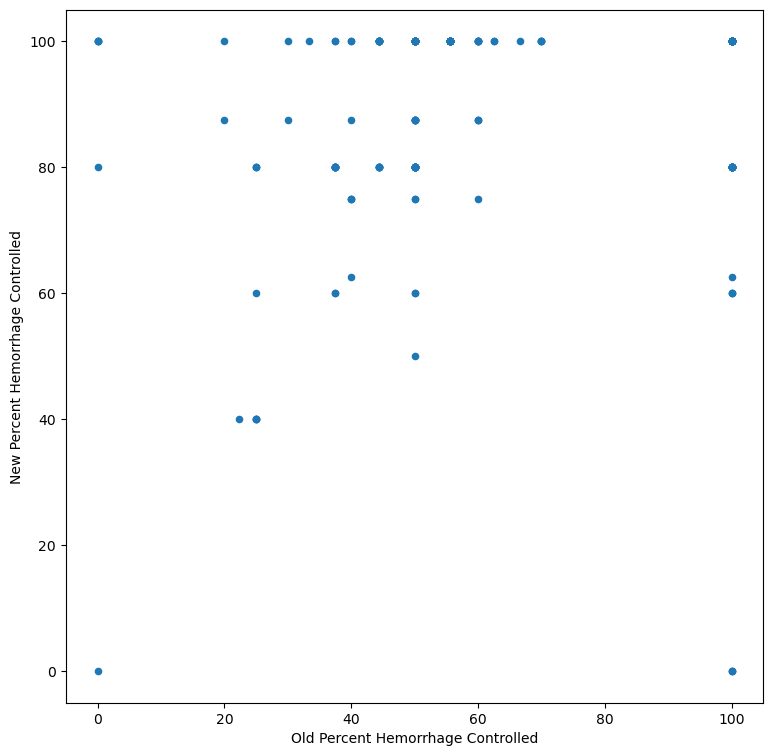

In [16]:

# Plot old and new percentage of hemorrhage cases successfully controlled
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
x_column_name = 'old_percent_hemorrhage_controlled'
y_column_name = 'new_percent_hemorrhage_controlled'
df.plot(x=x_column_name, y=y_column_name, kind='scatter', ax=ax)
x_label = ' '.join([w.title() for w in x_column_name.split('_')])
ax.set_xlabel(x_label)
y_label = ' '.join([w.title() for w in y_column_name.split('_')])
ax.set_ylabel(y_label);

In [18]:

# Compare old and new time it takes to control hemorrhage
scene_stats_df = nu.load_object('scene_stats_df')
# print(sorted(scene_stats_df.columns)); raise
rows_list = []
for (session_uuid, scene_id), old_scene_df in scene_stats_df.groupby(fu.scene_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
    old_time_to_last_hemorrhage_controlled = old_scene_df.time_to_last_hemorrhage_controlled.squeeze()
    row_dict['old_time_to_last_hemorrhage_controlled'] = old_time_to_last_hemorrhage_controlled

    # Get the whole scene history
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
    new_scene_df = elevens_df[mask_series]
    
    new_time_to_last_hemorrhage_controlled = fu.get_time_to_last_hemorrhage_controlled(new_scene_df, verbose=False)
    row_dict['new_time_to_last_hemorrhage_controlled'] = new_time_to_last_hemorrhage_controlled
    rows_list.append(row_dict)
df = DataFrame(rows_list)

In [7]:

mask_series = ~patient624_df.action_type.isnull()
sorted(patient624_df[mask_series].action_type.unique())

['INJURY_RECORD', 'INJURY_TREATED', 'PATIENT_DEMOTED', 'PATIENT_ENGAGED', 'PATIENT_RECORD', 'PULSE_TAKEN', 'S_A_L_T_WALKED', 'S_A_L_T_WALK_IF_CAN', 'S_A_L_T_WAVE_IF_CAN', 'TAG_APPLIED', 'TOOL_APPLIED']

In [8]:

actions_list = ['INJURY_TREATED', 'TOOL_APPLIED']
mask_series = patient624_df.action_type.isin(actions_list)
patient624_df[mask_series].dropna(axis='columns', how='all').sort_values('action_tick').T

,33275,33295,33296,33316,33317
action_type,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
action_tick,332915,336001,336001,338424,338426
event_time,2022-03-16 09:50:24,2022-03-16 09:50:27,2022-03-16 09:50:27,2022-03-16 09:50:29,2022-03-16 09:50:29
session_uuid,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681
injury_treated_id,NaN,L Forearm Laceration,NaN,L Forearm Laceration,NaN
injury_treated_patient_id,NaN,Gloria_8 Root,NaN,Gloria_8 Root,NaN
injury_treated_required_procedure,NaN,gauzePressure,NaN,gauzePressure,NaN
injury_treated_severity,NaN,low,NaN,low,NaN
injury_treated_body_region,NaN,leftArm,NaN,leftArm,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN



A great example of this is the EM Resident who applied a tourniquet to the R Calf Shrapnel injury on Gloria_6 Root and got no feedback from the sim, so tried packing gauze then dressing gauze.

In [16]:

from IPython.display import HTML

actions_list = ['INJURY_TREATED', 'TOOL_APPLIED']
mask_series = patient485_df.action_type.isin(actions_list)
print()
HTML(patient485_df[mask_series].dropna(axis='columns', how='all').sort_values('action_tick').T.to_html())

,33136,33154,33155,33176,33177
action_type,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
action_tick,241853,252143,252143,255316,255317
event_time,2022-03-16 09:48:53,2022-03-16 09:49:03,2022-03-16 09:49:03,2022-03-16 09:49:06,2022-03-16 09:49:06
session_uuid,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681
injury_treated_id,NaN,R Calf Shrapnel,NaN,R Calf Shrapnel,NaN
injury_treated_patient_id,NaN,Gloria_6 Root,NaN,Gloria_6 Root,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN,tourniquet,NaN
injury_treated_severity,NaN,medium,NaN,medium,NaN
injury_treated_body_region,NaN,rightLeg,NaN,rightLeg,NaN
injury_treated_injury_treated,NaN,False,NaN,False,NaN



Because there is no injury ID associated with the _TOOL_APPLIED_ logging event, no correct injury treatment exists.

In [17]:

print()
for injury_id, injury_df in patient485_df.groupby('injury_id'):
    is_controlled = False
    
    # Check if an injury record exists for a hemorrhage-related procedure
    record_mask_series = injury_df.injury_record_required_procedure.isin(fu.hemorrhage_control_procedures_list)
    is_controlled = record_mask_series.any()
    print(f'A hemorrhage-related injury record exists for {injury_id}: {is_controlled}')
    
    # Check if an injury treatment exists for a hemorrhage-related procedure
    treated_required_mask_series = injury_df.injury_treated_required_procedure.isin(fu.hemorrhage_control_procedures_list)
    is_controlled = treated_required_mask_series.any()
    print(f'A hemorrhage-related injury treatment exists for {injury_id}: {is_controlled}')

    # Check if the injury was treated
    treated_injury_mask_series = (injury_df.injury_treated_injury_treated == True)
    is_controlled = treated_injury_mask_series.any()
    print(f'The hemorrhage-related injury ({injury_id}) was treated: {is_controlled}')

    # Check if the injury was treated correctly
    wrong_treatment_mask_series = (injury_df.injury_treated_injury_treated_with_wrong_treatment == False)
    is_controlled = wrong_treatment_mask_series.any()
    print(f'The hemorrhage-related injury ({injury_id}) was treated correctly: {is_controlled}')
    
    # See if there are any hemorrhage-related tools applied to this patient that are associated with the required procedure of this injury
    applied_mask_series = False
    for required_procedure in injury_df[record_mask_series].injury_record_required_procedure.unique():
        tool_type = fu.required_procedure_to_tool_type_dict[required_procedure]
        applied_mask_series |= (patient485_df.tool_applied_type == tool_type)
    is_controlled = applied_mask_series.any()
    print(f'A hemorrhage-related TOOL_APPLIED event can be associated with the injury ({injury_id}): {is_controlled}')


A hemorrhage-related injury record exists for R Calf Shrapnel: True
A hemorrhage-related injury treatment exists for R Calf Shrapnel: True
The hemorrhage-related injury (R Calf Shrapnel) was treated: False
The hemorrhage-related injury (R Calf Shrapnel) was treated correctly: False
A hemorrhage-related TOOL_APPLIED event can be associated with the injury (R Calf Shrapnel): True


In [12]:

mask_series = (patient485_df.tool_applied_type == tool_type)
patient485_df[mask_series].dropna(axis='columns', how='all').sort_values('action_tick').T

,33136
action_type,TOOL_APPLIED
action_tick,241853
event_time,2022-03-16 09:48:53
session_uuid,b26d61b8-9027-4b16-ba3b-bc337bc6e681
tool_applied_type,Tourniquet
tool_applied_attachment_point,RightUpLeg (UnityEngine.GameObject)
tool_applied_tool_location,tor_ring (1) (UnityEngine.GameObject)
tool_applied_sender,tourniquet(Clone) (UnityEngine.GameObject)
tool_applied_attach_message,AppliedTourniquet
tool_applied_patient_id,Gloria_6 Root


In [13]:

fu.get_is_hemorrhage_controlled(injury_df, patient485_df, verbose=True)

Is the injury a hemorrhage: True





,32676,33154,33176
action_type,INJURY_RECORD,INJURY_TREATED,INJURY_TREATED
action_tick,14402,252143,255316
event_time,2022-03-16 09:45:05,2022-03-16 09:49:03,2022-03-16 09:49:06
session_uuid,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681
injury_record_id,R Calf Shrapnel,NaN,NaN
injury_record_patient_id,Gloria_6 Root,NaN,NaN
injury_record_required_procedure,tourniquet,NaN,NaN
injury_record_severity,medium,NaN,NaN
injury_record_body_region,rightLeg,NaN,NaN
injury_record_injury_treated,False,NaN,NaN


A hemorrhage-related injury record or treatment exists for R Calf Shrapnel: True
Was the injury correctly treated: False





,32676,33154,33176
action_type,INJURY_RECORD,INJURY_TREATED,INJURY_TREATED
action_tick,14402,252143,255316
event_time,2022-03-16 09:45:05,2022-03-16 09:49:03,2022-03-16 09:49:06
session_uuid,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681
injury_record_id,R Calf Shrapnel,NaN,NaN
injury_record_patient_id,Gloria_6 Root,NaN,NaN
injury_record_required_procedure,tourniquet,NaN,NaN
injury_record_severity,medium,NaN,NaN
injury_record_body_region,rightLeg,NaN,NaN
injury_record_injury_treated,False,NaN,NaN


The hemorrhage-related injury (R Calf Shrapnel) was treated correctly: False
A hemorrhage-related TOOL_APPLIED event can be associated with the injury (R Calf Shrapnel): True





,33136
action_type,TOOL_APPLIED
action_tick,241853
event_time,2022-03-16 09:48:53
session_uuid,b26d61b8-9027-4b16-ba3b-bc337bc6e681
tool_applied_type,Tourniquet
tool_applied_attachment_point,RightUpLeg (UnityEngine.GameObject)
tool_applied_tool_location,tor_ring (1) (UnityEngine.GameObject)
tool_applied_sender,tourniquet(Clone) (UnityEngine.GameObject)
tool_applied_attach_message,AppliedTourniquet
tool_applied_patient_id,Gloria_6 Root


Is hemorrhage controlled: True





,32676,33154,33176
action_type,INJURY_RECORD,INJURY_TREATED,INJURY_TREATED
action_tick,14402,252143,255316
event_time,2022-03-16 09:45:05,2022-03-16 09:49:03,2022-03-16 09:49:06
session_uuid,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681,b26d61b8-9027-4b16-ba3b-bc337bc6e681
injury_record_id,R Calf Shrapnel,NaN,NaN
injury_record_patient_id,Gloria_6 Root,NaN,NaN
injury_record_required_procedure,tourniquet,NaN,NaN
injury_record_severity,medium,NaN,NaN
injury_record_body_region,rightLeg,NaN,NaN
injury_record_injury_treated,False,NaN,NaN


True

# This is the Story of Mike_5


Mike appears in the logs right after a session-end but before a session-begin:


>SESSION_END,389471,6/12/2023 15:45,ad2137d0-d5aa-4a4e-af02-e327993c6d41,,,,,,,,,,,


>PATIENT_DEMOTED,398764,6/12/2023 15:46,ad2137d0-d5aa-4a4e-af02-e327993c6d41,100,Infinity,Mike_5 Root,"(2.4, 0.0, 2.3)","(0.0, 1.0, 0.0, 0.0)",IMMEDIATE,waver,fast,normal,normal,upset,fetal


>SESSION_START,404736,6/12/2023 15:46,ad2137d0-d5aa-4a4e-af02-e327993c6d41,,,,,,,,,,,


Mike has two injuries in need of hemorrhage control:


>PATIENT_RECORD,404737,6/12/2023 15:46,ad2137d0-d5aa-4a4e-af02-e327993c6d41,100,Infinity,Mike_5 Root,"(2.7, 0.0, 2.3)","(0.0, 1.0, 0.0, 0.0)",IMMEDIATE,waver,fast,normal,normal,upset,fetal


>INJURY_RECORD,404737,6/12/2023 15:46,ad2137d0-d5aa-4a4e-af02-e327993c6d41,R Side Puncture,Mike_5 Root,woundpack,medium,abdomen,FALSE,FALSE,"(2.6, 1.1, 2.2)",,, > ,


>INJURY_RECORD,404737,6/12/2023 15:46,ad2137d0-d5aa-4a4e-af02-e327993c6d41,R Thigh Laceration,Mike_5 Root,tourniquet,medium,rightLeg,FALSE,FALSE,"(2.5, 0.6, 2.2)",,,,,l,


Mike is asked to walk if he can:


>S_A_L_T_WALK_IF_CAN,415153,6/12/2023 15:46,ad2137d0-d5aa-4a4e-af02-e327993c6d41,"(2.7, 0.0, 2.3)",walkIfCan,Mike_5 Root,,,,,,,,,


Mike waves after he is asked to:


>S_A_L_T_WAVE_IF_CAN,426197,6/12/2023 15:46,ad2137d0-d5aa-4a4e-af02-e327993c6d41,"(2.7, 0.0, 2.3)",waveIfCan,Mike_5 Root,,,,,,,,,


>S_A_L_T_WAVED,426197,6/12/2023 15:46,ad2137d0-d5aa-4a4e-af02-e327993c6d41,"(2.7, 0.0, 2.3)",waved,Mike_5 Root,,,,,,,,,


Again, he is asked to walk:


>S_A_L_T_WALK_IF_CAN,575490,6/12/2023 15:49,ad2137d0-d5aa-4a4e-af02-e327993c6d41,"(2.7, 0.0, 2.3)",walkIfCan,Mike_5 Root,,,,,,,,,


Without ever logging a _PATIENT_ENGAGED_, one of his injuries is treated:


>TELEPORT,586184,6/12/2023 15:49,ad2137d0-d5aa-4a4e-af02-e327993c6d41,"(3.1, 0.0, 5.9)",,,,,,,,,,,


>INJURY_TREATED,595028,6/12/2023 15:49,ad2137d0-d5aa-4a4e-af02-e327993c6d41,R Thigh Laceration,Mike_5 Root,tourniquet,medium,rightLeg,TRUE,FALSE,"(3.0, 0.3, 2.2)",,,,


>TOOL_APPLIED,595028,6/12/2023 15:49,ad2137d0-d5aa-4a4e-af02-e327993c6d41,Mike_5 Root,Tourniquet,RightUpLeg (UnityEngine.GameObject),tor_ring (1) (UnityEngine.GameObject),tourniquet(Clone) (UnityEngine.GameObject),AppliedTourniquet,,,,,,


And a tag is applied:


>TAG_APPLIED,599115,6/12/2023 15:49,ad2137d0-d5aa-4a4e-af02-e327993c6d41,Mike_5 Root,red,,,,,,,,,,


>TELEPORT,601400,6/12/2023 15:49,ad2137d0-d5aa-4a4e-af02-e327993c6d41,"(3.1, 0.0, 3.9)",,,,,,,,,,,


A long time later, the system finally logs a _PATIENT_ENGAGED_ and he gets his other injury treated:


>TELEPORT,675206,6/12/2023 15:50,ad2137d0-d5aa-4a4e-af02-e327993c6d41,"(2.3, 0.0, 1.7)",,,,,,,,,,,


>PATIENT_ENGAGED,677073,6/12/2023 15:50,ad2137d0-d5aa-4a4e-af02-e327993c6d41,100,Infinity,Mike_5 Root,"(2.7, 0.0, 2.3)","(0.0, 1.0, 0.0, 0.0)",IMMEDIATE,waver,fast,normal,normal,upset,fetal


>INJURY_TREATED,684984,6/12/2023 15:50,ad2137d0-d5aa-4a4e-af02-e327993c6d41,R Side Puncture,Mike_5 Root,woundpack,medium,abdomen,TRUE,FALSE,"(3.1, 0.3, 2.5)",,,,


>TOOL_APPLIED,684984,6/12/2023 15:50,ad2137d0-d5aa-4a4e-af02-e327993c6d41,Mike_5 Root,Gauze_Pack,skinCollider_BodyCollideLOD (UnityEngine.GameObject),null,null,AppliedPackingGauze,,,,,,


# Challenge Encountered

In [4]:

search_regex = re.compile('^(tourniquet|woundpack)$')
regexed_columns = nu.get_regexed_columns(triage_paper_df, search_regex=search_regex, verbose=False)
regexed_df = nu.get_regexed_dataframe(triage_paper_df, regexed_columns, search_regex=search_regex, verbose=False)

In [5]:

import random

print(regexed_columns)
df = regexed_df.sample(min(8, regexed_df.shape[0])).dropna(axis='columns', how='all')
regexed_columns = sorted(set(regexed_columns).intersection(set(df.columns)))
# extra_columns = []
# if len(regexed_columns) < 20:
#     extra_count = 20 - len(regexed_columns)
#     extra_columns = random.sample(set(df.columns) - set(regexed_columns), extra_count)
# columns_list = list(set(extra_columns + regexed_columns).intersection(set(df.columns)))
df[regexed_columns].T.head(20)

['voice_capture_message', 'injury_record_required_procedure', 'injury_treated_required_procedure']


,8,128,98284
injury_record_required_procedure,woundpack,NaN,NaN
injury_treated_required_procedure,NaN,tourniquet,NaN
voice_capture_message,NaN,NaN,tourniquet


In [6]:

[cn for cn in triage_paper_df.columns if cn.endswith('_sort')]

['patient_demoted_sort', 'patient_record_sort', 'patient_engaged_sort']

In [7]:

mask_series = ~triage_paper_df.injury_id.isnull()
triage_paper_df[mask_series].action_type.unique().tolist()

['INJURY_RECORD', 'INJURY_TREATED']


## Task

We were trying to calculate time to hemorrhage control for scene defined as “time of start scene to time last hemorrhage control (last tourniquet applied)”.



    b.  Calculate time to hemorrhage control for scene defined as “time of start scene to time last hemorrhage control (last tourniquet applied)”

        Median = 3:51, SD = ±1:44, IQR = (2:41, 4:52)


## Situation

The FRVRS logger has trouble logging multiple tool applications. After the responder applied the packing and the dressing gauze, it logged another _INJURY_TREATED_, but with **injury_treated_injury_treated** == True and **injury_treated_injury_treated_with_wrong_treatment** == True. And even though he applied the right tool after that, another _INJURY_TREATED_ was never logged. So it must be combining the two _TOOL_APPLIEDs_, one with **injury_treated_injury_treated_with_wrong_treatment** == True (the _AppliedPackingGauze_) and one with **injury_treated_injury_treated** == True (the _AppliedTourniquet_).

In [9]:

from FRVRS import fu

# Filter out the non-aborted triage scenes in each one-per-file file
base_mask_series = (triage_paper_df.scene_type == 'Triage') & (triage_paper_df.is_scene_aborted == False) & (triage_paper_df.is_a_one_triage_file == True)

# Filter out the non-bleeders
procedures_list = ['tourniquet', 'woundpack']
mask_series = triage_paper_df.injury_record_required_procedure.isin(procedures_list) | triage_paper_df.injury_treated_required_procedure.isin(procedures_list)
mask_series = base_mask_series & mask_series

# Get the total scene count
total_scene_count = len(triage_paper_df[base_mask_series].groupby(fu.scene_groupby_columns).groups)

# Get the bleeder scene count
bleeder_scene_count = len(triage_paper_df[mask_series].groupby(fu.scene_groupby_columns).groups)
print(f'There are {bleeder_scene_count} scenes with bleeders in them out of a total of {total_scene_count} scenes.')

# Get the total patient count
total_patient_count = len(triage_paper_df[base_mask_series].groupby(fu.patient_groupby_columns).groups)

# Get the bleeder patient count
bleeder_patient_count = len(triage_paper_df[mask_series].groupby(fu.patient_groupby_columns).groups)
print(f'There are {bleeder_patient_count:,} bleeding patients out of a total of {total_patient_count:,} patients.')

# Get the non-engaged patient count
# mask_series = base_mask_series & triage_paper_df.patient_engaged_salt.isnull()

# Get the total injury count
total_injury_count = len(triage_paper_df[base_mask_series].groupby(fu.injury_groupby_columns).groups)

# Get the bleeding injury count
bleeding_injury_count = len(triage_paper_df[mask_series].groupby(fu.injury_groupby_columns).groups)
print(f'There are {bleeding_injury_count:,} bleeding injuries out of a total of {total_injury_count:,} injuries.')

There are 356 scenes with bleeders in them out of a total of 357 scenes.
There are 1,867 bleeding patients out of a total of 4,301 patients.
There are 3,188 bleeding injuries out of a total of 10,565 injuries.


In [10]:

if nu.pickle_exists('run_control_time_df'): run_control_time_df = nu.load_object('run_control_time_df')
else:
    
    # Iterate through each triage scene in each one-per-file file
    rows_list = []
    for (session_uuid, scene_id), scene_df in triage_paper_df[base_mask_series].groupby(fu.scene_groupby_columns):
        
        # Get the run start time
        time_start = fu.get_scene_start(scene_df)
        
        # Iterate through each patient in each triage scene
        for patient_id, patient_df in scene_df.groupby('patient_id'):
            
            # Get the engagement time
            mask_series = patient_df.action_type.isin(['PATIENT_ENGAGED'])
            patient_engaged = fu.get_scene_start(patient_df[mask_series])
    
            # Check if they are dead
            is_patient_dead = fu.get_is_patient_dead(patient_df)
            
            # Iterate through each injury of each patient
            for injury_id, injury_df in patient_df.groupby('injury_id'):
                row_dict = {}
                for cn in fu.injury_groupby_columns: row_dict[cn] = eval(cn)
                row_dict['scene_start'] = time_start
                row_dict['patient_engagement_time'] = patient_engaged
                row_dict['is_patient_dead'] = is_patient_dead
                
                # Is the patient bleeding?
                row_dict['is_injury_hemorrhage'] = fu.get_is_injury_hemorrhage(injury_df)
                row_dict['is_hemorrhage_controlled'] = fu.get_is_hemorrhage_controlled(injury_df, patient_df)
                bleeding_mask_series = injury_df.injury_record_required_procedure.isin(procedures_list)
                bleeding_mask_series |= injury_df.injury_treated_required_procedure.isin(procedures_list)
                if (1 <= injury_df[bleeding_mask_series].shape[0] <= 2):
                    
                    # Was the bleeding treated?
                    if (injury_df[bleeding_mask_series].shape[0] == 2):
                        
                        # Get the last tourniquet applied
                        time_stop = injury_df[mask_series].action_tick.max()
                        row_dict['bleeding_treated_time'] = time_stop
                        
                        # Get the time elapsed
                        row_dict['run_bleeding_control_delta'] = time_stop - time_start
                        row_dict['engaged_bleeding_control_delta'] = time_stop - patient_engaged
                
                rows_list.append(row_dict)
    
    # Store the run control data frame
    run_control_time_df = DataFrame(rows_list)
    nu.store_objects(run_control_time_df=run_control_time_df, verbose=True)

Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/run_control_time_df.pkl


In [11]:

columns_list = ['is_patient_dead', 'is_hemorrhage_controlled']
df = nu.get_minority_combinations(run_control_time_df, columns_list)
scene_groups = df.groupby(fu.scene_groupby_columns).groups
display(df.T)

,4124,2312,93,2767
session_uuid,b0f6e371-e548-4e1d-adc1-92891a6ca6ca,61dba1bb-2326-48f9-968f-9e0e4c867eee,04acc8f2-1e64-47b2-9606-8d661f584aec,7407aba4-aef4-4012-be6c-a237d225809d
scene_id,1,1,1,1
patient_id,Military Mike Jungle Burned_0 Root,Mike_5 Root,Bob_0 Root,Helga_10 Root
injury_id,L Neck Puncture,R Side Puncture,L Thigh Laceration,Forehead Scrape
scene_start,109727,327482,450483,327068
patient_engagement_time,184773.0,519596.0,572116.0,949019.0
is_patient_dead,True,False,True,False
is_injury_hemorrhage,True,True,True,False
is_hemorrhage_controlled,True,True,False,False
bleeding_treated_time,NaN,NaN,NaN,NaN


In [12]:

mask_series = run_control_time_df.is_patient_dead.isnull()
df = run_control_time_df[~mask_series]
scene_groups = df.groupby(fu.scene_groupby_columns).groups
df.drop_duplicates(subset=columns_list).dropna(axis='columns', how='all').T.head(20)

,0,6,12,4124
session_uuid,009b848c-ea64-4f22-bd40-711213a3d327,009b848c-ea64-4f22-bd40-711213a3d327,009b848c-ea64-4f22-bd40-711213a3d327,b0f6e371-e548-4e1d-adc1-92891a6ca6ca
scene_id,0,0,0,1
patient_id,Bob_0 Root,Bob_9 Root,Lily_2 Root,Military Mike Jungle Burned_0 Root
injury_id,Face Shrapnel,Ear Bleed,R Shin Amputation,L Neck Puncture
scene_start,296666,296666,296666,109727
patient_engagement_time,704250.0,NaN,409276.0,184773.0
is_patient_dead,True,False,False,True
is_injury_hemorrhage,False,False,True,True
is_hemorrhage_controlled,False,False,True,True


In [13]:

group_tuple = [g for g, idx_list in scene_groups.items() if (list(idx_list) == [6])][0]
mask_series = (triage_paper_df.session_uuid == group_tuple[0]) & (triage_paper_df.scene_id == group_tuple[1])# & (triage_paper_df.patient_id == 'Bob_0 Root')
mask_series &= ~triage_paper_df.action_type.isin(['VOICE_CAPTURE', 'PATIENT_DEMOTED', 'INJURY_RECORD'])
triage_paper_df.loc[mask_series].sort_values('action_tick').head(8).dropna(axis='columns', how='all').T.head(20)

IndexError: list index out of range

In [14]:

columns_list = [cn for cn in run_control_time_df.columns if cn.endswith('_delta')]
df = run_control_time_df.groupby(fu.scene_groupby_columns).max().reset_index(drop=False)[fu.scene_groupby_columns + columns_list]
mask_series = ~df.run_bleeding_control_delta.isnull() & ~df.engaged_bleeding_control_delta.isnull()
df[mask_series]

,session_uuid,scene_id,run_bleeding_control_delta,engaged_bleeding_control_delta


In [15]:

groupby_columns = ['is_injury_hemorrhage', 'is_hemorrhage_controlled']
df = run_control_time_df.groupby(groupby_columns).size().to_frame().rename(columns={0: 'injury_count'}).reset_index(drop=False)
display(df)
total_count = df.injury_count.sum()
mask_series = (df.is_injury_hemorrhage == True)
hemorrhage_count = df[mask_series]['injury_count'].sum()
not_hemorrhage_count = df[~mask_series]['injury_count'].sum()
mask_series = (df.is_injury_hemorrhage == True) & (df.is_hemorrhage_controlled == True)
controlled_count = df[mask_series]['injury_count'].sum()
mask_series = (df.is_injury_hemorrhage == True) & (df.is_hemorrhage_controlled == False)
not_controlled_count = df[mask_series]['injury_count'].sum()
print(
    f'Of the {total_count:,} injuries, {not_hemorrhage_count:,} are not hemorrhages. Of the {hemorrhage_count:,} injuries that are,'
    f' {not_controlled_count:,} are not controlled.'
)

,is_injury_hemorrhage,is_hemorrhage_controlled,injury_count
0,False,False,3255
1,True,False,1585
2,True,True,1424


Of the 6,264 injuries, 3,255 are not hemorrhages. Of the 3,009 injuries that are, 1,585 are not controlled.


In [18]:

base_mask_series = (triage_paper_df.scene_type == 'Triage') & (triage_paper_df.is_scene_aborted == False) & (triage_paper_df.is_a_one_triage_file == True)
gb = triage_paper_df[base_mask_series].groupby(fu.injury_groupby_columns)

scene_action_types_set = set()
patient_action_types_set = set()
injury_action_types_set = set()

# Iterate through each injury of each patient in each triage scene in each one-per-file file
for (session_uuid, scene_id, patient_id, injury_id), injury_df in gb:
    bleeding_mask_series = injury_df.injury_record_required_procedure.isin(procedures_list) | injury_df.injury_treated_required_procedure.isin(procedures_list)
    if (1 <= injury_df[bleeding_mask_series].shape[0] <= 2):
        
        # Get the entire history of this scene
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (triage_paper_df[cn] == eval(cn))
        scene_df = triage_paper_df[mask_series]
        
        # Get the action types associated with the relevent action history of this scene
        mask_series = scene_df.action_type.isin(['PATIENT_RECORD', 'INJURY_RECORD', 'PATIENT_ENGAGED', 'TOOL_SELECTED', 'TOOL_APPLIED', 'INJURY_TREATED'])
        # display(scene_df[mask_series].dropna(axis='columns', how='all').T); raise
        for action_type in scene_df[mask_series].action_type.unique(): scene_action_types_set.add(action_type)
        
        # Get the entire history of this patient
        mask_series = True
        for cn in fu.patient_groupby_columns: mask_series &= (triage_paper_df[cn] == eval(cn))
        patient_df = triage_paper_df[mask_series]
        
        # Get the action types associated with the relevent action history of this patient
        mask_series = patient_df.action_type.isin(['PATIENT_RECORD', 'INJURY_RECORD', 'PATIENT_ENGAGED', 'TOOL_SELECTED', 'TOOL_APPLIED', 'INJURY_TREATED'])
        # display(patient_df[mask_series].dropna(axis='columns', how='all').T); raise
        for action_type in patient_df[mask_series].action_type.unique(): patient_action_types_set.add(action_type)
        
        # Get the action types associated with the relevent action history of this injury
        mask_series = injury_df.action_type.isin(['TOOL_SELECTED', 'PATIENT_RECORD', 'INJURY_RECORD', 'PATIENT_ENGAGED', 'TOOL_APPLIED', 'INJURY_TREATED'])
        # display(injury_df[mask_series].dropna(axis='columns', how='all').T); raise
        for action_type in injury_df[mask_series].action_type.unique(): injury_action_types_set.add(action_type)

In [19]:

# {'TOOL_SELECTED'}
scene_action_types_set - patient_action_types_set

{'TOOL_SELECTED'}

In [20]:

# {'PATIENT_RECORD', 'TOOL_APPLIED', 'PATIENT_ENGAGED', 'INJURY_TREATED'}
patient_action_types_set - injury_action_types_set

{'PATIENT_ENGAGED', 'TOOL_APPLIED', 'PATIENT_RECORD'}

In [21]:

# {'INJURY_RECORD'}
injury_action_types_set

{'INJURY_RECORD', 'INJURY_TREATED'}

In [23]:

# Get the total and bleeder scene count
base_mask_series = (triage_paper_df.scene_type == 'Triage') & (triage_paper_df.is_scene_aborted == False) & (triage_paper_df.is_a_one_triage_file == True)
mask_series = base_mask_series & triage_paper_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
total_scene_count = len(triage_paper_df[base_mask_series].groupby(fu.scene_groupby_columns).groups)
gb = triage_paper_df[mask_series].groupby(fu.scene_groupby_columns)
bleeder_scene_count = len(gb.groups)

# Iterate through each one-per-file, triage bleeder scene in each file
rows_list = []
file_names_set = set()
is_first_one = True
for (session_uuid, scene_id), tourniquet_required_scene_df in gb:
    row_dict = {}
    for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    
    # Get the entire history of this scene for the run start
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (triage_paper_df[cn] == eval(cn))
    scene_df = triage_paper_df[mask_series]
    time_start = fu.get_scene_start(scene_df)
    row_dict['scene_start'] = time_start

    # Iterate through each bleeding patient in the scene
    bleeding_mask_series = scene_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
    for patient_id, tourniquet_required_patient_df in scene_df[bleeding_mask_series].groupby('patient_id'):
        for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
        row_dict['is_patient_bleeding'] = fu.get_is_injury_hemorrhage(patient_df)
        
        # Get the entire history of this patient
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (triage_paper_df[cn] == eval(cn))
        mask_series &= (triage_paper_df.patient_id == patient_id)
        patient_df = triage_paper_df[mask_series]
        columns_list = sorted([
            'injury_treated_required_procedure', 'injury_record_patient_id', 'injury_treated_patient_id', 'tool_applied_patient_id', 'injury_record_id',
            'injury_treated_id', 'tool_applied_sender', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment', 'action_tick',
            'action_type', 'file_name', 'patient_id', 'injury_id'
        ])
        # display(patient_df[columns_list].dropna(axis='columns', how='all').T); raise
        
        # Get the time of patient engagement
        mask_series = patient_df.action_type.isin(['PATIENT_ENGAGED'])
        patient_engaged = fu.get_scene_start(patient_df[mask_series])
        row_dict['patient_engagement_time'] = patient_engaged
        
        # Get the entire history of the patients that had these injuries
        injury_mask_series = True
        for cn in fu.scene_groupby_columns: injury_mask_series &= (triage_paper_df[cn] == eval(cn))
        injury_mask_series &= (
            (triage_paper_df.injury_record_patient_id == patient_id) |
            (triage_paper_df.injury_treated_patient_id == patient_id) |
            (triage_paper_df.tool_applied_patient_id == patient_id)
        )
        
        # Add the entire history of these injuries
        injury_ids_list = patient_df[bleeding_mask_series].injury_treated_id.tolist()
        injury_mask_series &= (
            triage_paper_df.injury_record_id.isin(injury_ids_list) |
            triage_paper_df.injury_treated_id.isin(injury_ids_list) |
            triage_paper_df.injury_id.isnull()
        )
        # injury_mask_series &= triage_paper_df.action_type.isin(['INJURY_RECORD', 'TOOL_APPLIED', 'INJURY_TREATED'])
        
        injury_records_df = triage_paper_df[injury_mask_series]

        # Was the correct tool applied?
        row_dict['is_correct_tool_applied'] = fu.get_is_correct_bleeding_tool_applied(injury_records_df)
        mask_series = injury_records_df.tool_applied_sender.isin(['AppliedTourniquet', 'AppliedPackingGauze'])
        if mask_series.any():
            
            # Get the last tourniquet applied
            time_stop = fu.get_scene_end(injury_records_df[mask_series])
            row_dict['tool_applied_time'] = time_stop
            
            # Get the time elapsed
            row_dict['run_tool_control_time'] = time_stop - time_start
            row_dict['engaged_tool_control_time'] = time_stop - patient_engaged
        
        # Was the bleeding treated?
        is_bleeding_treated = fu.get_is_injury_correctly_treated(injury_records_df)
        row_dict['is_bleeding_treated'] = is_bleeding_treated
        if is_bleeding_treated:
            
            # Get the last tourniquet applied
            time_stop = fu.get_injury_correctly_treated_time(injury_records_df)
            row_dict['bleeding_treated_time'] = time_stop
            
            # Get the time elapsed
            row_dict['run_bleeding_control_delta'] = time_stop - time_start
            row_dict['engaged_bleeding_control_delta'] = time_stop - patient_engaged
        
        elif (row_dict['is_correct_tool_applied'] == True): 
            columns_list = ['injury_treated_injury_treated', 'tool_applied_sender']
            idx_list = injury_records_df[columns_list].drop_duplicates().index.tolist()
            mask_series = triage_paper_df.index.isin(idx_list)
            columns_list = sorted([
                'injury_treated_required_procedure', 'injury_record_patient_id', 'injury_treated_patient_id', 'tool_applied_patient_id', 'injury_record_id',
                'injury_treated_id', 'tool_applied_sender', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment', 'action_tick',
                'action_type', 'file_name'
            ])
            df = triage_paper_df[mask_series][columns_list].sort_values('action_tick')
            if (df.tool_applied_sender.unique().shape[0] > 1):
                if is_first_one:
                    display(df.T)
                    is_first_one = False
                file_name = fu.get_file_name(df)
                file_names_set.add(file_name)
                print(
                    f'In {file_name} (or {fu.get_new_file_name(file_name)}), search for these integers in the second column:'
                    f"\n(?:^[^,]+,)({'|'.join([str(n) for n in df.action_tick.unique()])})(?:,)\n"
                )
    
    rows_list.append(row_dict)
run_control_time_df = DataFrame(rows_list)

,229887,230195,230196,230218,230219
action_tick,19447,211276,211276,222197,222198
action_type,INJURY_RECORD,INJURY_TREATED,TOOL_APPLIED,INJURY_TREATED,TOOL_APPLIED
file_name,Disaster Day 2022/CH_1115.csv,Disaster Day 2022/CH_1115.csv,Disaster Day 2022/CH_1115.csv,Disaster Day 2022/CH_1115.csv,Disaster Day 2022/CH_1115.csv
injury_record_id,L Side Puncture,NaN,NaN,NaN,NaN
injury_record_patient_id,Lily_4 Root,NaN,NaN,NaN,NaN
injury_treated_id,NaN,L Side Puncture,NaN,L Side Puncture,NaN
injury_treated_injury_treated,NaN,False,NaN,True,NaN
injury_treated_injury_treated_with_wrong_treatment,NaN,True,NaN,True,NaN
injury_treated_patient_id,NaN,Lily_4 Root,NaN,Lily_4 Root,NaN
injury_treated_required_procedure,NaN,woundpack,NaN,woundpack,NaN


In Disaster Day 2022/CH_1115.csv (or Disaster Day 2022/22.03.16.1108.csv), search for these integers in the second column:
(?:^[^,]+,)(19447|211276|222197|222198)(?:,)

In DCEMS Round 2 only triage sessions/4a504e80-0232-4978-9a63-7e503e86c5e3.csv (or DCEMS Round 2 only triage sessions/23.08.02.1316.csv), search for these integers in the second column:
(?:^[^,]+,)(48509|327456|332815|342980)(?:,)

In DCEMS Round 2 only triage sessions/Kami P.csv (or DCEMS Round 2 only triage sessions/23.07.26.1242.csv), search for these integers in the second column:
(?:^[^,]+,)(33336|101961|105179)(?:,)

In All CSV files renamed by date/11.30.22.0957.csv (or All CSV files renamed by date/22.11.30.0948.csv), search for these integers in the second column:
(?:^[^,]+,)(23625|208776|214305|216946)(?:,)

In DCEMS Round 2 only triage sessions/68f0ccd0-ecbc-4b90-b5d1-83d9517995b8.csv (or DCEMS Round 2 only triage sessions/23.08.02.0802.csv), search for these integers in the second column:
(?:^[^,]+,)(26471|2

In [24]:

set([
    'injury_treated_required_procedure', 'injury_record_patient_id', 'injury_treated_patient_id', 'tool_applied_patient_id', 'injury_record_id',
    'injury_treated_id', 'tool_applied_sender', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment', 'action_tick',
    'action_type', 'file_name'
]) - set([
    'action_type', 'action_tick', 'event_time', 'session_uuid', 'file_name', 'logger_version', 'patient_demoted_health_level', 'patient_demoted_health_time_remaining',
    'patient_demoted_patient_id', 'patient_demoted_position', 'patient_demoted_rotation', 'patient_demoted_salt', 'patient_demoted_sort', 'patient_demoted_pulse',
    'patient_demoted_breath', 'patient_demoted_hearing', 'patient_demoted_mood', 'patient_demoted_pose', 'patient_record_health_level',
    'patient_record_health_time_remaining', 'patient_record_id', 'patient_record_position', 'patient_record_rotation', 'patient_record_salt', 'patient_record_sort',
    'patient_record_pulse', 'patient_record_breath', 'patient_record_hearing', 'patient_record_mood', 'patient_record_pose', 'injury_record_id',
    'injury_record_patient_id', 'injury_record_required_procedure', 'injury_record_severity', 'injury_record_body_region', 'injury_record_injury_treated',
    'injury_record_injury_treated_with_wrong_treatment', 'injury_record_injury_injury_locator', 's_a_l_t_walk_if_can_sort_location',
    's_a_l_t_walk_if_can_sort_command_text', 's_a_l_t_walk_if_can_patient_id', 's_a_l_t_wave_if_can_sort_location', 's_a_l_t_wave_if_can_sort_command_text',
    's_a_l_t_wave_if_can_patient_id', 's_a_l_t_waved_sort_location', 's_a_l_t_waved_sort_command_text', 's_a_l_t_waved_patient_id', 'pulse_taken_pulse_name',
    'pulse_taken_patient_id', 'patient_engaged_health_level', 'patient_engaged_health_time_remaining', 'patient_engaged_id', 'patient_engaged_position',
    'patient_engaged_rotation', 'patient_engaged_salt', 'patient_engaged_sort', 'patient_engaged_pulse', 'patient_engaged_breath', 'patient_engaged_hearing',
    'patient_engaged_mood', 'patient_engaged_pose', 'injury_treated_id', 'injury_treated_patient_id', 'injury_treated_required_procedure', 'injury_treated_severity',
    'injury_treated_body_region', 'injury_treated_injury_treated', 'injury_treated_injury_treated_with_wrong_treatment', 'injury_treated_injury_injury_locator',
    'tool_applied_type', 'tool_applied_attachment_point', 'tool_applied_tool_location', 'tool_applied_data', 'tool_applied_sender', 'tag_applied_patient_id',
    'tag_applied_type', 'tool_applied_patient_id', 'scene_id', 'patient_id', 'location_id', 'injury_id', 'is_scene_aborted', 'scene_type', 'is_a_one_triage_file'
])

set()


## Action

Ashu called a meeting with Brian Pippin and others as this fork of the FRVRS logger isn't the only one. Dave is making this notebook to demonstrate the problem.

In [13]:

# Why are these two scenes not identical?
mask_series = (scene624_df == scene485_df).all()
scene624_df.columns[mask_series]

Index(['action_type', 'action_tick', 'event_time', 'session_uuid', 'scene_id',
       'is_a_one_triage_file', 'responder_category', 'responder_type',
       'is_scene_aborted', 'scene_type'],
      dtype='object')